# Predict the listing prices of second-hand cars

In [458]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import r2_score
from random import randint, uniform
import json

## Data exploration

In [307]:
df = pd.read_json("data/train.json")
test_df = pd.read_json("data/test.json")
df.head(2)

,marca,model,an,km,putere,cutie_de_viteze,combustibil,capacitate_cilindrica,transmisie,caroserie,culoare,optiuni_culoare,addons,pret,id
0,Opel,Opel_Astra,2008,283100,115,Manuala,Benzina + CNG/GPL,1598,Fata,Masina de oras,Gri,Metalizata,"[Radio, Sistem audio, Control vocal, Climatron...",3650,0
1,Volkswagen,Volkswagen_Tiguan,2017,215994,190,Automata,Diesel,1968,4x4 (automat),SUV,Negru,Metalizata,"[Apple Carplay, Bluetooth, Radio, Sistem navig...",17950,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20245 entries, 0 to 20244
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   marca                  20245 non-null  object
 1   model                  20245 non-null  object
 2   an                     20245 non-null  int64 
 3   km                     20245 non-null  int64 
 4   putere                 20245 non-null  int64 
 5   cutie_de_viteze        20245 non-null  object
 6   combustibil            20245 non-null  object
 7   capacitate_cilindrica  20245 non-null  int64 
 8   transmisie             20245 non-null  object
 9   caroserie              20245 non-null  object
 10  culoare                20245 non-null  object
 11  optiuni_culoare        20245 non-null  object
 12  addons                 20245 non-null  object
 13  pret                   20245 non-null  int64 
 14  id                     20245 non-null  int64 
dtypes: int64(6), object

In [18]:
print("How many car brands?", df["marca"].nunique())
print(f"The price ranges from {df['pret'].min()} to {df['pret'].max()}")
print(f"The mileage ranges from {df['km'].min()} to {df['km'].max()}")

transmission_counts = df["cutie_de_viteze"].value_counts()
print(f"Number of cars with manual transmission {transmission_counts.get('Manuala')} vs automatic {transmission_counts.get('Automata')}")

How many car brands? 52
The price ranges from 250 to 99980
The mileage ranges from 1 to 450000
Number of cars with manual transmission 8393 vs automatic 11852


In [16]:
df["marca"].value_counts()

marca
Volkswagen        2765
BMW               2718
Mercedes-Benz     2129
Audi              1896
Ford              1397
Skoda             1256
Renault            991
Dacia              961
Opel               708
Toyota             578
Volvo              557
Peugeot            441
Nissan             418
Land Rover         391
Hyundai            388
Mazda              309
Seat               270
Kia                264
Citroën            215
Porsche            198
Mitsubishi         147
Fiat               146
Jeep               137
Suzuki             128
Honda              122
Jaguar             114
Mini               111
Lexus               95
Alfa Romeo          86
Maserati            48
Chevrolet           45
SsangYong           41
Smart               31
Subaru              30
Cupra               21
DS Automobiles      17
Dodge               14
Infiniti            10
Aixam                9
Iveco                6
Bentley              6
Lancia               5
Isuzu                5
GMC  

In [15]:
df["an"].value_counts()

an
2018    2810
2019    2096
2017    2096
2016    1420
2022    1255
2015    1114
2020    1102
2012    1100
2011    1058
2014    1027
2021     972
2013     969
2010     709
2009     575
2008     506
2007     402
2006     311
2023     235
2005     182
2004     107
2003      79
2001      51
2002      49
2000      20
Name: count, dtype: int64

In [17]:
df["capacitate_cilindrica"].value_counts()

capacitate_cilindrica
1968    2734
1995    1719
1598    1622
1461    1198
2993     978
        ... 
996        1
5935       1
2178       1
2972       1
3696       1
Name: count, Length: 307, dtype: int64

### Plot the number of cars against the a given column

In [22]:
def plot_car_count_vs_column(dataframe, column_name):
    car_count = dataframe[column_name].value_counts()
    plt.figure(figsize=(10, 6))
    car_count.plot(kind="bar", color="green")
    plt.title(f"Number of cars vs {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Number of cars")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

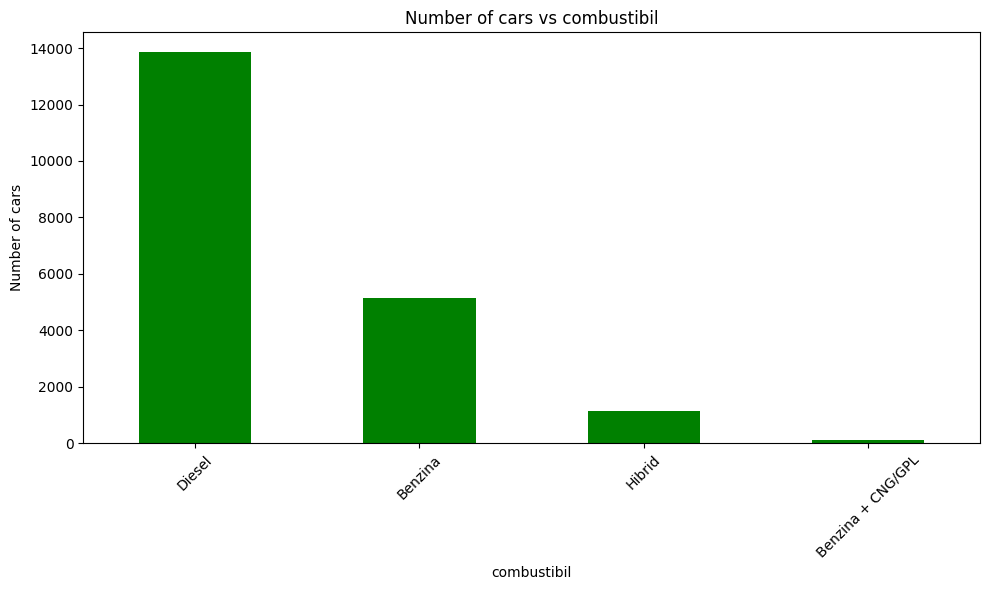

In [23]:
plot_car_count_vs_column(df, "combustibil")

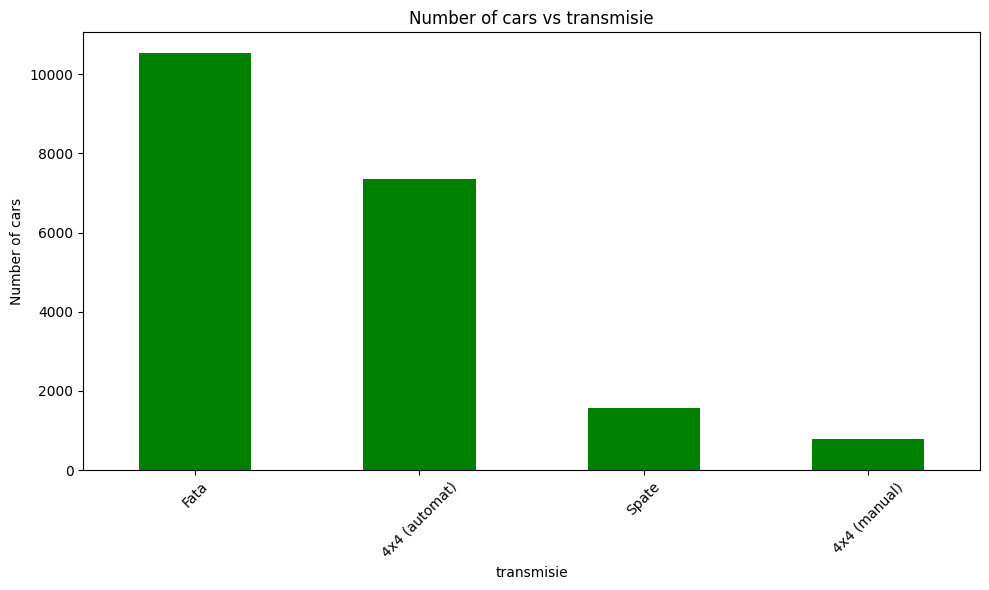

In [24]:
plot_car_count_vs_column(df, "transmisie")

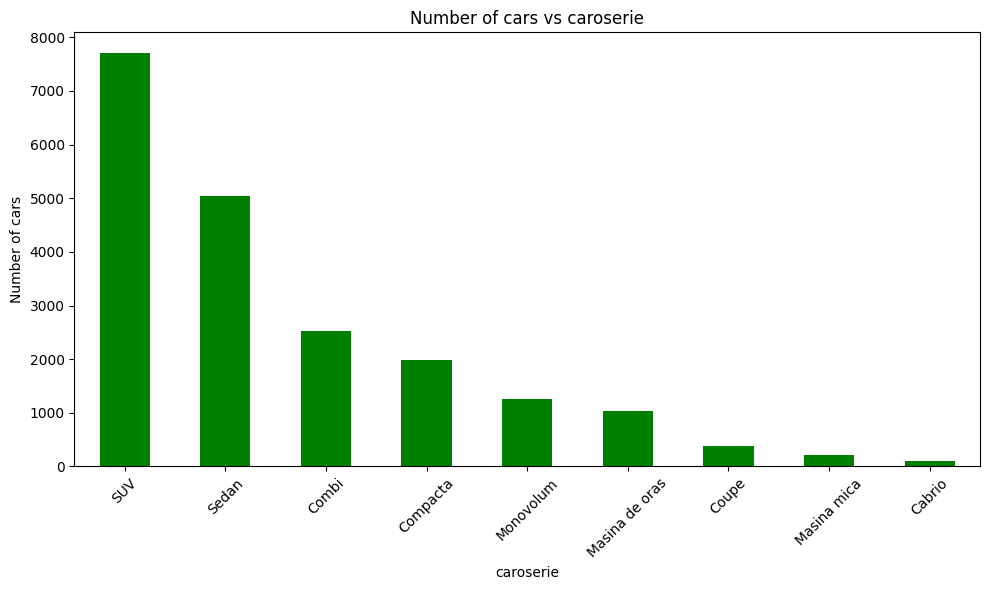

In [25]:
plot_car_count_vs_column(df, "caroserie")

### Visualize the distribution of cars based on intervals of mileage (50k)

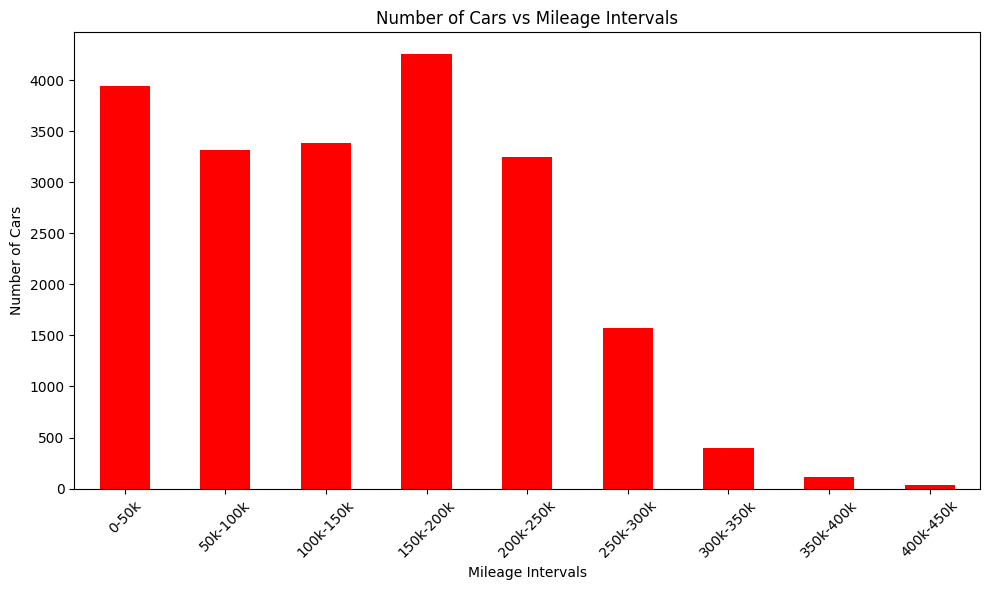

In [19]:
interval_ranges = [
    0,
    50000,
    100000,
    150000,
    200000,
    250000,
    300000,
    350000,
    400000,
    450000,
]
interval_labels = [
    "0-50k",
    "50k-100k",
    "100k-150k",
    "150k-200k",
    "200k-250k",
    "250k-300k",
    "300k-350k",
    "350k-400k",
    "400k-450k",
]

df_intervals = pd.cut(
    df["km"], bins=interval_ranges, labels=interval_labels, right=False
)
interval_counts = df_intervals.value_counts().sort_index()

plt.figure(figsize=(10, 6))
interval_counts.plot(kind="bar", color="red")
plt.title("Number of Cars vs Mileage Intervals")
plt.xlabel("Mileage Intervals")
plt.ylabel("Number of Cars")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Preprocessing

### Make copy of dataframe

In [430]:
df_tmp = df.copy()
df_tmp.drop("id", axis=1, inplace=True)

### Preprocess `make` and `model`
* A. Keep both columns and remove chars before `_` for the `model` column
* B. Drop `make` column and split `model` by `_`

In [431]:
# A
df_tmp["model"] = df_tmp["model"].apply(lambda x: x.split("_")[-1])

# remove rows containing ['']
df_tmp = df_tmp[df_tmp.astype(str)["addons"] != "['']"]

### Split dataframe before preprocessing

In [432]:
X = df_tmp.drop("pret", axis=1)
y = df_tmp["pret"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15071, 13), (3768, 13), (15071,), (3768,))

### Encode make and model with LabelEncoder

In [433]:
# assign unique integers with label encoder
def encode_model_and_make(X):
    label_encoder = LabelEncoder()
    X["marca"] = label_encoder.fit_transform(X["marca"])
    X["model"] = label_encoder.fit_transform(X["model"])
    return X

X_train = encode_model_and_make(X_train)
X_test = encode_model_and_make(X_test)

### Encode `addons`

In [434]:
def encode_extra_options(df):
    mlb = MultiLabelBinarizer()
    encoded_data = mlb.fit_transform(df["addons"])
    encoded_df = pd.DataFrame(encoded_data, columns=mlb.classes_)
    result = pd.concat([df, encoded_df], axis=1)
    result.drop("addons", axis=1, inplace=True)
    return result

In [397]:
X_train = encode_extra_options(X_train)
X_test = encode_extra_options(X_test)

### Drop rows containing `NaN` values after encoding

In [398]:
X_train.dropna(inplace=True)
print(X_train.shape)

X_test.dropna(inplace=True)
print(X_test.shape)

(11166, 194)
(685, 193)


### Encode cateogorical columns with one-hot encoding

In [435]:
categorical_columns = ["cutie_de_viteze", "transmisie", "caroserie", "combustibil", "optiuni_culoare", "culoare"]

for column in categorical_columns:
    X_train[column] = X_train[column].astype("category")
    X_test[column] = X_test[column].astype("category")

In [436]:
X_train.drop("addons", axis=1, inplace=True)
X_test.drop("addons", axis=1, inplace=True)

In [437]:
one_hot = OneHotEncoder()
transformer = ColumnTransformer(
    [
        ("one_hot", one_hot, categorical_columns),
    ],
    remainder="passthrough")
transformed_X_train = transformer.fit_transform(X_train)
transformed_X_test = transformer.transform(X_test)

## Modeling

In [440]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Support Vectort Machine": SVR(),
    "XGBoost": xgb.XGBRegressor(),
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)

    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        model_scores[name] = r2_score(y_test, preds)
    return model_scores

fit_and_score(models, transformed_X_train, transformed_X_test, y_train, y_test)

{'Linear Regression': 0.7914462868080687,
 'Random Forest': 0.9263797768452264,
 'Support Vectort Machine': -0.005157043023501284,
 'XGBoost': 0.9134121042821917}

## Hyperparameters tuning

### Random Forest

In [445]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300, 400],
    "max_depth": [None, 3, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
)
grid_search.fit(transformed_X_train, y_train)

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

preds = best_rf_model.predict(transformed_X_test)

r2 = r2_score(y_test, preds)
print(f"R2 score: {r2}")
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


/Users/alex9popa/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


R2 score: 0.9267175053200253
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


### XG boost

In [ ]:
xgb_reg = xgb.XGBRegressor()

max_depth = [3, 5, 7, 10, 20, 30]
booster = ["gbtree", "gblinear", "dart"]
subsample = [0.2, 0.5, 0.7, 1.0]
colsample_bytree = [0.1, 0.25, 0.5, None]
n_estimators = [50, 100, 150, 200, 300, 500]
learning_rates = [0.15, 0.01, 0.001, 0.05, 0.5]
reg_alpha =  [0, 0.01, 0.1, 1, 10]
min_child_weights =  [1, 3, 5, 7]
gamma = [0, 0.1, 0.2, 0.3]

random_grid = {
    "max_depth": max_depth,
    "booster": booster,
    "subsample": subsample,
    "colsample_bytree": colsample_bytree,
    "n_estimators": n_estimators,
    "learning_rate": learning_rates,
    "min_child_weight": min_child_weights,
    "reg_alpha": reg_alpha,
    "gamma": gamma,
}

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=random_grid,
    n_iter=100,
    cv=5,
    scoring="r2",
    random_state=42,
    n_jobs=-1,
)
random_search.fit(transformed_X_train, y_train)

best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

preds = best_xgb_model.predict(transformed_X_test)

r2 = r2_score(y_test, preds)
print(f"R2 score: {r2}")
print(f"Best Hyperparameters: {best_params}")

## Construct `test.json`

In [453]:
test_df = pd.read_json("data/test.json")
X = test_df.copy()

X.drop("id", axis=1, inplace=True)
X.drop("addons", axis=1, inplace=True)
X.shape

(5045, 13)

In [454]:
X = encode_model_and_make(X)

for column in categorical_columns:
    X[column] = X[column].astype("category")

transformed_X = transformer.transform(X)
preds = best_rf_model.predict(transformed_X)
len(preds)

5045

In [455]:
preds[:10]

array([25632.62      , 10188.33333333,  5870.65333333,  2182.        ,
       38939.32      , 37668.        ,  2543.88      , 11201.09333333,
       17642.36      ,  9914.82666667])

In [457]:
test_df["pret"] = preds
test_df["pret"]

0       25632.620000
1       10188.333333
2        5870.653333
3        2182.000000
4       38939.320000
            ...     
5040     3476.566667
5041    44803.026667
5042     5720.153333
5043     4214.833333
5044    20651.166667
Name: pret, Length: 5045, dtype: float64

In [459]:
with open("data/filled_test.json", "w") as file:
    json.dump(test_df.to_dict(orient="records"), file, indent=4)